https://towardsdatascience.com/predict-the-number-of-likes-on-instagram-a7ec5c020203

# Imports

In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from lib.utils import clean_sentence, clean_text, extract_date_info, embedings2df
from lib.preprocess import calc_duration, transform_to_year, aggregate_transactions

In [5]:
import pandas as pd
import json
import numpy as np
import re
import pickle
from datetime import datetime
import tqdm

from PIL import Image
import requests
from io import BytesIO

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

from bert_embedding import BertEmbedding

# import nltk
# import deeppavlov
import gensim
import gc
# from pymystem3 import Mystem
from gensim.models.wrappers import FastText

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [9]:
DATA_PATH = '../data_like/'

In [10]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')

stories = pd.read_csv(DATA_PATH+'stories_description.csv')

train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

transaction = pd.read_csv(DATA_PATH+'transactions.csv')

# Extracting text features from jsons

In [5]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","
NUM_SWIPES = "description\":\"[0-9]{1,2}"

r = re.findall(REG_NAME, stories['story_json'][10])

In [6]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    story_info['name'] = "" if len(name) == 0 else clean_sentence(name[0])
    story_info['text'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    story_info['swipes'] = len(re.findall(NUM_SWIPES, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [7]:
CATEGORY = "text\":\"[А-ЯA-Z]+\""

In [10]:
# with open("stories", "rb") as fp:
#     b = pickle.load(fp)

# Extracting images from jsons

In [126]:
URL_STORY = '"url":"([A-Za-z0-9:\/._]+tinkoff[A-Za-z0-9:\/._]+)"'
IMG_URL_STORY = '"image_url":"([A-Za-z0-9:\/._]+tinkoff[A-Za-z0-9:\/._]+)"'

In [130]:
images = dict()
for i in stories.index:
    idx = stories['story_id'][i]
    cur_story = stories['story_json'][i]
    images[idx] = re.findall(URL_STORY, cur_story) + re.findall(IMG_URL_STORY, cur_story)  

In [134]:
# with open("../PreprocessedData/url_stories", "wb") as fp:
#     pickle.dump(images, fp)

# Data Analysis 

## 1) Likes, Dislikes and other stuff

#### Customers can watch the same stories few times, can be a good feature

In [13]:
train_y.event.value_counts() / len(train_y)

view       0.512135
skip       0.354159
like       0.119810
dislike    0.013896
Name: event, dtype: float64

top_liked : top_disliked  ==  31 <br>
top_viewed : top_disliked  ==  22 <br>
top_skiped : top_disliked  ==  20 <br>
top_viewed : top_liked  == 29 <br>
top_skiped : top_liked == 24 <br>
top_viewed : top_skiped == 27 <br>

### ???? disliked are much more similar to liked, may be it is a misclick of user ?????

## 2) Users info

## 3) Transactions

#### There are a lot of popular shops, maybe like x5 

In [17]:
len(transaction.merchant_mcc.value_counts())

409

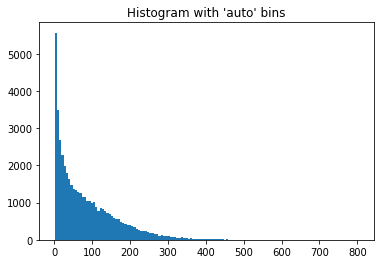

514522     804
588639     788
333041     768
588106     700
673392     690
          ... 
542958       1
462666       1
743422       1
1010076      1
195566       1
Name: customer_id, Length: 46948, dtype: int64

In [18]:
_ = plt.hist(transaction.customer_id.value_counts(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
transaction.customer_id.value_counts()

#### Ideas: <br> 1. average amount of money for transaction for each user, two features: average over all transactions and of >0 rubles transactions<br> 2. average number of transaction per month <br> 3. Maybe if user visits top popular shops 

# -----------------------------

# Preprocessing

# -1) BERT Embedding

In [11]:
#  BertEmbedding(dataset_name='../PretrainedEmbeddings/rubert_cased_L-12_H-768_A-12_v2.tar')

In [4]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('../PretrainedEmbeddings/rubert_cased_L-12_H-768_A-12_v2.tar')

UsageError: Line magic function `%` not found.


In [ ]:
vector = bse.get_vector('Привет как дела лол', word_vector=False, layer=-1)   # 3rd line 1. get vector of string

## 0) Extracting images

In [49]:
url = 'https://static2.tinkoff.ru/portfolio/stories/images/57_3.png'

In [50]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [70]:
np.array(img.convert('RGB')).shape

(864, 1920, 3)

## 1) Customer_train/test

Порезаьть те вещи, которые я указал выше - done<br>
Посчитать число лет от текущего момента - done <br>
Переделать дату - done

In [15]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')
print(train.shape)
print(test.shape)

(50000, 15)
(54245, 15)


#### Cutting very rare stuff

In [16]:
train.age = train.age.fillna(np.mean(train.age.dropna()))
test.age = test.age.fillna(np.mean(test.age.dropna()))

In [17]:
nan = 'NAN'
train = train.fillna(nan)
test = test.fillna(nan)

### Важная часть, перенес ниже

In [18]:
# Delete rare jobs because it may be useless during one-hot encoding
# train.job_title = [job.lower() if isinstance(job, type('aaa')) else job for job in train.job_title]
# common_jobs = set(train['job_title'].value_counts().keys()[train['job_title'].value_counts() > 25])
# train.job_title = [job if job in common_jobs else nan for job in train.job_title]

# test.job_title = [job.lower() if isinstance(job, type('aaa')) else job for job in test.job_title]
# common_jobs = set(test['job_title'].value_counts().keys()[test['job_title'].value_counts() > 25])
# test.job_title = [job if job in common_jobs else nan for job in test.job_title]

In [19]:
# common_n_status = set(train['marital_status_cd'].value_counts().keys()[train['marital_status_cd'].value_counts() > 2])
# train.marital_status_cd = [ch if ch in common_n_status else nan for ch in train.marital_status_cd]

#### Calculating amount of time since regestration till now

In [20]:
calc_duration(train)
calc_duration(test)

#### Transform data of reg to Year of registration

In [21]:
transform_to_year(train)
transform_to_year(test)

#### One-Hot-Encode

In [22]:
print(train.shape)
print(test.shape)

(50000, 16)
(54245, 16)


In [23]:
X = pd.concat((train, test))

In [24]:
X.job_title = [job.lower() if isinstance(job, type('aaa')) else job for job in X.job_title]
common_jobs = set(X['job_title'].value_counts().keys()[X['job_title'].value_counts() > 30])
X.job_title = [job if job in common_jobs else nan for job in X.job_title]

In [25]:
X.shape

(104245, 16)

In [26]:
features_to_encode = ['product_0', 'product_1', 'product_2', 'product_3',
                      'product_4', 'product_5', 'product_6', 'gender_cd',
                      'marital_status_cd', 'children_cnt', 'first_session_dttm',
                      'job_position_cd', 'job_title']
train_transformed = pd.get_dummies(X, columns=features_to_encode)

In [27]:
train = train_transformed.iloc[0: train.shape[0]]
test = train_transformed.iloc[train.shape[0]: ]

In [28]:
train.shape

(50000, 275)

In [29]:
test.shape

(54245, 275)

In [30]:
train_transformed.index = train_transformed['customer_id']
train_transformed = train_transformed.drop(columns='customer_id')

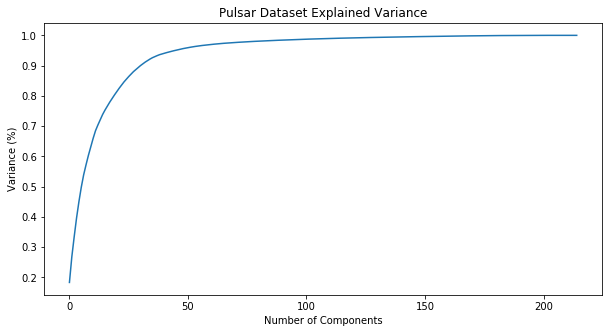

In [36]:
#Fitting the PCA algorithm with our Data
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(train_transformed, )
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

## 2) Transactions

Средняя сумма транзакций с нулями и без - done <br>
Кол-во транзакций с нулями и без - done <br>

In [37]:
transactions = aggregate_transactions(DATA_PATH+'transactions.csv')

In [38]:
transactions.head()

,av,av_n_z,num_tr,num_tr_n_z
15,22210.000000,23627.659574,100.0,2221000.0
73,3768.852459,5063.876652,305.0,1149500.0
91,3588.983051,4505.319149,118.0,423500.0
144,1000.000000,1250.000000,5.0,5000.0
150,0.000000,0.000000,4.0,1.0


In [39]:
# with open("../PreprocessedData/transactions", "wb") as fp:
#     pickle.dump(transactions, fp)

## 3) Stories

In [71]:
stories = pd.read_csv(DATA_PATH+'stories_description.csv')

In [72]:
model = FastText.load_fasttext_format('../PretrainedEmbeddings/cc.ru.300.bin')

In [97]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","
NUM_SWIPES = "description\":\"[0-9]{1,2}"

In [98]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    name = "" if len(name) == 0 else clean_sentence(name[0]).split()
    name_n = []
    for w in name:
        if len(w) > 1:
            name_n.append(w)
    story_info['name'] = name_n
    story_info['text'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    story_info['swipes'] = len(re.findall(NUM_SWIPES, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [99]:
embedded_stories = dict()
for key in decoded_stories.keys():
    cur_story = decoded_stories[key]
    cur_emb = np.zeros(300)
    for i in range(len(cur_story['text'])):
        try:
            cur_emb += np.average(model.wv[cur_story['text'][i]], axis=0)
        except KeyError:
            continue
    try:
        cur_emb += np.average(model.wv[cur_story['name']], axis=0)
    except:
        pass
    cur_emb = (cur_emb - np.mean(cur_emb)) / (np.std(cur_emb) + 1e-8)
    embedded_stories[key] = {'emb': cur_emb,
                             'n_words': cur_story['n_words'],
                             'swipes' : cur_story['swipes']
                            }

In [100]:
# with open("../PreprocessedData/embedded_stories_сс", "wb") as fp:
#     pickle.dump(embedded_stories, fp)

### Make categories

In [31]:
embedings_df = embedings2df('../PreprocessedData/embedded_stories_сс')

n_clusters = 10

k_means = KMeans(n_clusters=n_clusters)
clusters = k_means.fit_predict(embedings_df) 

100%|██████████| 959/959 [00:00<00:00, 1258947.59it/s]


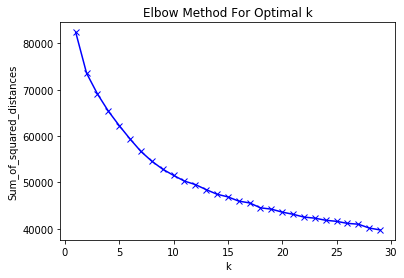

In [173]:
Sum_of_squared_distances = []
K = range(1, 30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(embedings_df)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 4) Whatching the same stories twice

Смотрел ужк или нет <br>
Сколько раз смотрел на текущий момент

In [ ]:
train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

In [ ]:
train_y.head()

In [ ]:
y = pd.concat([train_y.drop(columns='event'), test_y.drop(columns='answer_id')])

In [ ]:
y.index = y.customer_id
y = y.drop(columns='customer_id')

In [ ]:
idxs = np.unique(y.index)
customer_views = dict()
for id_c in tqdm.tqdm(idxs):
    cur_y = y.loc[id_c]
    cur_customer_views = dict()
    for story in np.unique(cur_y['story_id']):
        cur_story = dict()
        dates = cur_y[cur_y['story_id'] == story]
        # print(type(dates), story)
        if type(dates) != type('aaa'):
            dates = np.array(dates['event_dttm'])
        else:
            dates = [dates]
        dates = sorted([datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in dates])
        for j in range(len(dates)):
            cur_story[dates[j]] = j
        cur_customer_views[story] = cur_story
    customer_views[id_c] = cur_customer_views

In [136]:
# with open("../PreprocessedData/customer_views", "wb") as fp:
#     pickle.dump(customer_views, fp)

#### Extracting Day of week of view and etc 

Рабочее время или нет (9-18) + выходной или нет <br>
День недели (как категориальная фича) - Monday == 0 ... Sunday == 6 <br>
Выходной или нет (Бинарная фича) - выходной: метки 5 и 6 <br>

## 5) Aggregating all previous into one dataset

#### Loading previous preprocess

In [67]:
with open("../PreprocessedData/transactions", "rb") as fp:
    transactions = pickle.load(fp)

In [68]:
with open("../PreprocessedData/embedded_stories_сс", "rb") as fp:
    embedded_stories = pickle.load(fp)
for i, idx in enumerate(embedings_df.index):
    cluster = [0] * (n_clusters+1)
    cluster[clusters[i]] = 1
    embedded_stories[idx]['category'] = cluster

In [69]:
with open("../PreprocessedData/customer_views", "rb") as fp:
    customer_views = pickle.load(fp)

In [70]:
train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

#### Not all cusomers from trani_y are in transactions, so swap their info to average

In [71]:
av_transaction = list(np.mean(transactions, axis=0))

In [72]:
av_transaction

[1212.4871354047252, 1792.7243260481805, 84.15938911135724, 82035.79185481809]

#### Not all stories from train_y are in stories, so swap their info to average. Maybe we should just drop them from dataset??

In [73]:
embs = np.zeros(300)
words = 0
swipes = 0
num_stories = len(embedded_stories.keys())
for key in embedded_stories.keys():
    embs += embedded_stories[key]['emb']
    words += embedded_stories[key]['n_words']
    swipes += embedded_stories[key]['swipes']

In [74]:
av_story = {'emb': embs / num_stories,
            'n_words': words // num_stories,
            'swipes': swipes // num_stories,
            'category': [0]*n_clusters + [1]
           }

In [75]:
column_names = []

In [76]:
column_names += list(train_transformed.columns)
column_names += list(transactions.columns)

In [77]:
story_feat = ['emb_'+str(i+1) for i in range(300)]
story_cat = ['cat_'+str(i+1) for i in range(n_clusters+1)]
column_names += ['n_words', 'swipes']
column_names += story_feat
column_names += story_cat

In [78]:
column_names += ['num_prev', 'is_prev']
print(len(column_names))

593


In [79]:
column_names += ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'] +\
                ['is_weekend', 'is_working_time', 'is_daytime']
print(len(column_names))

603


In [80]:
def final_preprocess(y, train_transformed, bonus, transactions, embedded_stories, customer_views, label_col='event'):
    final_df = []
    final_labels = []
    for i in tqdm.tqdm(range(len(y))):
        row = []
        cur_view = y.iloc[i]

        cus_id = cur_view['customer_id']
        try:
            row += list(train_transformed.loc[cus_id])
        except KeyError:
            try:
                row += list(bonus.loc[cus_id])
            except KeyError:
                continue
        try:
            row += list(transactions.loc[cus_id])
        except KeyError:
            row += av_transaction

        story_id = cur_view['story_id']
        try:
            story = embedded_stories[story_id]
        except KeyError:
            story = av_story
        row += [story['n_words']]
        row += [story['swipes']]
        row += list(story['emb'])
        row += story['category']

        view_date = datetime.strptime(cur_view['event_dttm'], '%Y-%m-%d %H:%M:%S')
        num_prev = customer_views[cus_id][story_id][view_date]
        if num_prev:
            row += [num_prev, 1]
        else:
            row += [num_prev, 0]
        row += extract_date_info(view_date)
        final_df.append(row)
        final_labels.append(cur_view[label_col])
        
    return final_df, final_labels

In [81]:
train = train_transformed.iloc[0: train.shape[0]]
test = train_transformed.iloc[train.shape[0]: ]

In [82]:
train_fin, train_label_fin = final_preprocess(train_y, train, test, transactions, embedded_stories,
                                              customer_views, label_col='event')

100%|██████████| 473141/473141 [05:33<00:00, 1420.15it/s]


In [83]:
test_fin, test_label_fin = final_preprocess(test_y, test, train, transactions, embedded_stories,
                                            customer_views, label_col='answer_id')

100%|██████████| 172049/172049 [02:00<00:00, 1432.55it/s]


In [93]:
np.array(test_fin).shape

(172049, 603)

In [94]:
test_y.shape

(172049, 4)

In [95]:
np.array(train_fin).shape

(473141, 603)

In [96]:
train_y.shape

(473141, 4)

In [97]:
del(embedded_stories)
del(transactions)
del(customer_views)
del(train_transformed)
del(train)
del(test)
gc.collect()

NameError: name 'embedded_stories' is not defined

In [ ]:
# np.save("../PreprocessedData/FinalDataset/train_data", np.array(train_fin))
# np.save("../PreprocessedData/FinalDataset/train_labels", np.array(train_label_fin))
# np.save("../PreprocessedData/FinalDataset/test_data", np.array(test_fin))
# np.save("../PreprocessedData/FinalDataset/test_labels", np.array(test_label_fin))

### Запихнем в датафрейм с названиями колонок, чтобы можно было чекать фича импортансы

In [89]:
train_fin_df = pd.DataFrame(train_fin, columns=column_names)

In [90]:
test_fin_df = pd.DataFrame(test_fin, columns=column_names)

In [91]:
train_fin_df.to_csv('../PreprocessedData/FinalDatasetBonusFeatures_сс/train_data.csv', sep=',', index=False)
test_fin_df.to_csv('../PreprocessedData/FinalDatasetBonusFeatures_сс/test_data.csv', sep=',',  index=False)

In [92]:
np.save("../PreprocessedData/FinalDatasetBonusFeatures_сс/train_labels", np.array(train_label_fin))
np.save("../PreprocessedData/FinalDatasetBonusFeatures_сс/test_labels", np.array(test_label_fin))